In [510]:
import numpy as np
import scipy as sp

import sympy as sy


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cvxopt
import picos as pic


In [511]:
#create a Problem instance (note that picos was imported at the top of this notebook)
prob = pic.Problem()

T = 10 # seconds, the time horizon of optimisation 
dt = 1 #seconds, the time step of optimisation 
#size of the storage for all the values of different signals
# in the opt horizon and per step time (needs to be integer)
ssize = int(T/dt) 

# num of sats per time step which is of type integer 
s_NumSat = prob.add_variable('s_NumSat', ssize, vtype = 'integer') 

#jammed/not jammed state per time step which is of type binary 
s_Jam = prob.add_variable('s_Jam', ssize, vtype = 'binary') 

# sky angle knob per time step which is of type continuous
u_SkyAngle = prob.add_variable('u_SkyAngle', ssize, vtype = 'integer') 

# on/off knob per time step which is of type binary
u_Power = prob.add_variable('u_Power', ssize, vtype = 'binary')

# -----------------------------------------boundary Constraints 

max_sat = 17
min_sat = 0
max_angle = 10
min_angle = 0

# num of satellites seen is above zero
prob.add_constraint( s_NumSat[:] >= min_sat)   
 # num of satellites seen is below 17
prob.add_constraint( s_NumSat[:] <= max_sat) 
# sky angle knob goes up only up to 10 degrees
prob.add_constraint( u_SkyAngle[:] <= max_angle)
# sky angle knob goes down only up to 0 degrees
prob.add_constraint( u_SkyAngle[:] >= min_angle) 



#----------------------------------------- Model Constraints
# first two values are jammed signal are not controllable
prob.add_constraint( s_Jam[1] == s_Jam[0] )

# this new binary variable captures if reset was not done correctly 
noreset = prob.add_variable ('noreset', ssize, vtype = 'binary')
prob.add_constraint( noreset[0] == 1) #noreset is initially active

epsilon = .2
M = 1000
# new variable to contain AND of being jammed
#in the previous step and not having done reset either
jam_noreset = prob.add_variable ('jam_noreset', ssize, vtype = 'binary')

#jam_noreset is initially based on whether GPS is jammed initially
prob.add_constraint(jam_noreset[0] == s_Jam[0]) 


for i in range (ssize-2):
    
    # if GPS is not jammed it will remain unjammed (during the planning period),
    # even after we have managed to get it out the jammed state
    prob.add_constraint( s_Jam[i+1] <=  s_Jam[i] )
    
    
 
    
    #equation relating sky angle to number of sats
    prob.add_constraint( s_NumSat[i+2] == s_NumSat[i+1] + u_SkyAngle[i] - u_SkyAngle[i+1]) 
    
    #equation saying GPS_off will kill the sats
    prob.add_constraint( s_NumSat[i+1] <= max_sat * u_Power[i+1])

    #equation saying GPS_Jammed will kill the sats
    prob.add_constraint( s_NumSat[i+1] <= max_sat * (1- s_Jam[i+1]))

    #equation saying don't be an idiot changing the sky angle if GPS is off or if it is jammed 
    prob.add_constraint (abs(u_SkyAngle[i+1] - u_SkyAngle[i]) <= M * u_Power[i+1] )  
    prob.add_constraint (abs(u_SkyAngle[i+1] - u_SkyAngle[i]) <= M * (1- s_Jam[i+1] ) )                    
    
    #equation saying how to reset GPS to get out of jammed state
    prob.add_constraint( s_Jam[i+2] <= -1  + u_Power[i+1] - u_Power[i]  + M * (1-u_Power[i+1]) + M * u_Power[i])
    
    
    
    # noreset variable update (u_Power[i]=0 AND u_Power[i+1] = 1 => noreset[i+1] = 0 else 1)
    prob.add_constraint( u_Power[i+1] - u_Power[i] <= (1 - noreset[i+1]))
    prob.add_constraint( u_Power[i+1] - u_Power[i] >= epsilon + (-1 - epsilon) * noreset[i+1])
    
    
    # jammed AND noreset variable update
    prob.add_constraint( -s_Jam[i+1] + jam_noreset[i+1] <= 0  ) 
    prob.add_constraint( -noreset[i+1] + jam_noreset[i+1]  <= 0  ) 
    prob.add_constraint( s_Jam[i+1] + noreset[i+1] - jam_noreset[i+1]  <= 1  ) 
    
    # if jammed and not done reset will remain jammed
    prob.add_constraint( -s_Jam[i+2] + jam_noreset[i+1]  <= 0  ) 
    
# these were not captured in the previous loop    
prob.add_constraint( s_NumSat[1] == s_NumSat[0])
prob.add_constraint( s_Jam[ssize-1] <=  s_Jam[ssize-2] )



prob.add_constraint( s_NumSat[ssize-1] <= M * (1- s_Jam[ssize-1]))


prob.add_constraint( s_NumSat[ssize-1] <=  M * u_Power[ssize-1] )



prob.add_constraint (abs(u_SkyAngle[ssize-1] - u_SkyAngle[ssize-2]) <= M * u_Power[ssize-1])
prob.add_constraint (abs(u_SkyAngle[ssize-1] - u_SkyAngle[ssize-2]) <= M * (1 - s_Jam[ssize-1]))                     

#-------------------------------------------- Initial Condition Constraints

initial_sat  = 6
initial_angle = 10 
initial_jam = 0
initial_power = 0

prob.add_list_of_constraints([s_NumSat[0] == initial_sat,
                              s_Jam[0] == initial_jam,
                              u_Power[0] == initial_power,
                              u_SkyAngle[0] == initial_angle],'initial conditions')

# ------------------------------------------- Objective Function

Nominal_input  = 8 
input_weight = 2

Nominal_sats = 6
sat_weight = 3

Nominal_jam = 0
jam_weight = 10


ObjFunc = (input_weight * ((u_SkyAngle[0:ssize-1] - Nominal_input)|(u_SkyAngle[0:ssize-1] - Nominal_input))
            + 0 * (jam_noreset[1:ssize - 1]|1)
            + sat_weight *((s_NumSat[0:ssize-1] - Nominal_sats)|(s_NumSat[0:ssize-1] - Nominal_sats))
            + sat_weight *((s_NumSat[-1] - Nominal_sats)|(s_NumSat[-1] - Nominal_sats))
            + jam_weight * (s_Jam[2]|s_Jam[3]) )


prob.set_objective('min', ObjFunc )
#print(prob)

prob.solve(solver='gurobi',verbose=0)
# note that the optimisation problem is solved fast enough
# in 6 milliseconds!  

 
    
                            

{'gurobi_model': <gurobi.Model MIP instance Unnamed: 175 constrs, 60 vars, Parameter changes: OptimalityTol=1e-08, BarQCPConvTol=1e-08, LogFile=gurobi.log, OutputFlag=0>,
 'obj': -2184.0,
 'status': 'OPTIMAL',
 'time': 0.0022459030151367188}

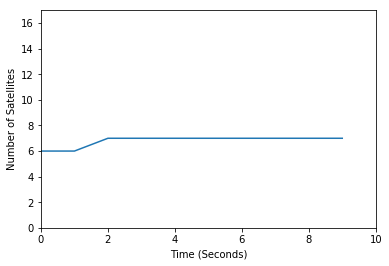

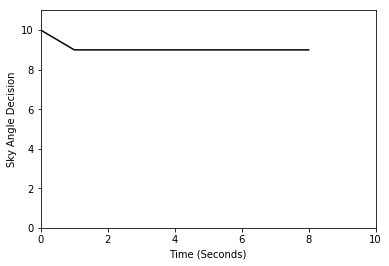

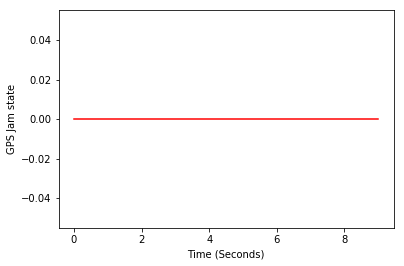

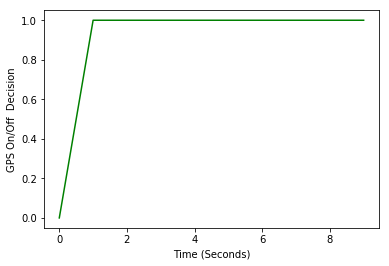

In [512]:
# Plotting a sample results of planning to check if the planner is working fine 

plt.plot(prob.get_valued_variable('s_NumSat'))
plt.ylabel('Number of Satellites')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, 0, 17])
plt.show()

plt.plot(prob.get_valued_variable('u_SkyAngle')[:ssize-1], 'k')
plt.ylabel('Sky Angle Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, 0, 11])
plt.show()

plt.plot(prob.get_valued_variable('s_Jam'), 'r')
plt.ylabel('GPS Jam state')
plt.xlabel('Time (Seconds)')
plt.show()



plt.plot(prob.get_valued_variable('u_Power'), 'g')
plt.ylabel('GPS On/Off  Decision')
plt.xlabel('Time (Seconds)')
plt.show()

In [513]:
# actual simulation time horizon 
T_Sim = 200

# size of the storage variables dt is the same as the time step for point optimisation
size_Sim = int (T_Sim/dt )

# the horizon for planning/optimisation
T_Opt = 6

# initialising the storage array for the variables of the problem
s_NumSat_Sim = [0] * size_Sim
s_NumSat_Sim_0  = initial_sat
s_NumSat_Sim[0] = s_NumSat_Sim_0
s_NumSat_Sim[1] = s_NumSat_Sim_0


s_NumSat_Plan = [0] * size_Sim
s_NumSat_Plan_0  = initial_sat
s_NumSat_Plan[0] = s_NumSat_Plan_0
s_NumSat_Plan[1] = s_NumSat_Plan_0

s_Jam_Sim = [0] * size_Sim
s_Jam_Sim_0 = initial_jam
s_Jam_Sim[0] = s_Jam_Sim_0
s_Jam_Sim[1] = s_Jam_Sim_0


s_Jam_Plan = [0] * size_Sim
s_Jam_Plan_0 = initial_jam
s_Jam_Plan[0] = s_Jam_Plan_0
s_Jam_Plan[1] = s_Jam_Plan_0



u_Power_Sim = [0] * size_Sim
u_Power_Sim_0 = initial_power
u_Power_Sim[0] = u_Power_Sim_0


u_SkyAngle_Sim = [0] * size_Sim
u_SkyAngle_Sim_0 = initial_angle
u_SkyAngle_Sim[0] = u_SkyAngle_Sim_0

# disturbance of the zone
d_z = 0

# zone times
time_z1 = 49
time_z2 = 98
time_z3 = 140

    
# this is the main loop of the simulation 
i = 0
while (i <= size_Sim - T_Opt - 2):
    
    
    print i
    
    # reset the variables of the solver
    prob.reset_gurobi_instance()
    
    # remove the initial conditions for the solver
    prob.remove_constraint((-1,))
    
    
    # Changing the zone and the objectives based on the new context
    if (i== time_z1):
        
        # entering a zone with good seen sattelites
        s_NumSat_Sim[i] = 10
        u_SkyAngle_Sim[i] = 10
        
        s_NumSat_Sim[i+1] = s_NumSat_Sim[i]
        s_Jam_Sim[i+1] = s_Jam_Sim[i]
    
        
#         Nominal_input  = 8 
#         input_weight = 4 

#         Nominal_sats = 8
#         sat_weight = 4 

#         Nominal_jam = 0
#         jam_weight = 10
    
    # Changing the zone and the objectives based on the new context
    if (i== time_z2):
        
        # entering a zone with low seen sattelites
        s_NumSat_Sim[i] = 3
        u_SkyAngle_Sim[i] = 10
        
        s_NumSat_Sim[i+1] = s_NumSat_Sim[i]
        s_Jam_Sim[i+1] = s_Jam_Sim[i]
       
        
#         Nominal_input  = 2 
#         input_weight = 4 

#         Nominal_sats = 5
#         sat_weight = 4 

#         Nominal_jam = 0
#         jam_weight = 10
      
    # Changing the zone and the objectives based on the new context
    if (i== time_z3):
        
        # entering a zone with jammed sattelites
        s_NumSat_Sim[i] = 0
        s_Jam_Sim[i] = 1
        u_SkyAngle_Sim[i] = 10
        
        s_NumSat_Sim[i+1] = s_NumSat_Sim[i]
        s_Jam_Sim[i+1] = s_Jam_Sim[i]
        
#         Nominal_input  = 4 
#         input_weight = 4 

#         Nominal_sats = 8
#         sat_weight = 4 

#         Nominal_jam = 0
#         jam_weight = 10
    
        
    

    # add the updated states and variables for the initial conditions of the solver
    prob.add_list_of_constraints([s_NumSat[0] == s_NumSat_Sim[i],
                              s_Jam[0] == s_Jam_Sim[i],
                              u_Power[0] == u_Power_Sim[i],
                              u_SkyAngle[0] == u_SkyAngle_Sim[i]],'initial conditions')
    
    
        


    ObjFunc = (input_weight * ((u_SkyAngle[0:ssize-1] - Nominal_input)|(u_SkyAngle[0:ssize-1] - Nominal_input))
            + 0 * (jam_noreset[1:ssize - 1]|1)
            + sat_weight *((s_NumSat[0:ssize-1] - Nominal_sats)|(s_NumSat[0:ssize-1] - Nominal_sats))
            + sat_weight *((s_NumSat[-1] - Nominal_sats)|(s_NumSat[-1] - Nominal_sats))
            + jam_weight * (s_Jam[2]|s_Jam[3]) )


    prob.set_objective('min', ObjFunc )
    
    
    #solve for the next N steps
    prob.solve(solver='gurobi',verbose=0)
    
    # this is the execution loop of the simulation in which for T_Opt steps
    # the plan of the planner is applied to the GPS configurations
    
    
    
    for j in range (T_Opt ):
        
        
        #reading the plan from the solver for two steps
        u_SkyAngle_Sim[i + j] = int (prob.get_valued_variable ('u_SkyAngle')[j])
        u_Power_Sim[i + j] = int(prob.get_valued_variable ('u_Power')[j])
        
        u_SkyAngle_Sim[i+j+1] = int(prob.get_valued_variable ('u_SkyAngle')[j+1])
        u_Power_Sim[i+j+1] = int(prob.get_valued_variable ('u_Power')[j+1])
        
        

        
        #disturbance signal randint returns uniformly probable an integer between [lower upper) upper not included.  
        d = d_z * np.random.randint(-1,2) 
        
    
        
        # how the jam state is decided
        nextJam = 0
        
        if (s_Jam_Sim[i + j +1]==0 and  (i + j +1) == size_Sim ):
            nextJam=1
        elif ( u_Power_Sim[i+j+1]==1 and u_Power_Sim[i+j]==0 ):
            nextJam = 0
        else :
            nextJam = s_Jam_Sim[i+j+1]
        s_Jam_Sim[i+j+2] = nextJam
        
        
        # how the actual number of satellites is decided 
        s_NumSat_Sim[i+j+2] = int((abs((s_NumSat_Sim[i+j+1] + u_SkyAngle_Sim[i+j] - u_SkyAngle_Sim[i+j+1] + d))
                                   * (1-s_Jam_Sim[i+j+2]) * u_Power_Sim[i+j+1]))
                                        
        
        # storing what the planner had predicted for the states
        s_NumSat_Plan[i+j] = int(prob.get_valued_variable ('s_NumSat')[j])
        s_Jam_Plan[i+j] = int(prob.get_valued_variable ('s_Jam')[j])
    
    # house keeping for the interplay of the inner and outer loop (you can ignore these)
    i = i + T_Opt + 1    
    u_Power_Sim[i]  = u_Power_Sim[i - 1]
    u_SkyAngle_Sim[i] = u_SkyAngle_Sim[i - 1]
    s_NumSat_Sim[i+1] = s_NumSat_Sim[i]
    s_Jam_Sim[i+1] = s_Jam_Sim[i]
    s_NumSat_Plan [i-1] = int(prob.get_valued_variable ('s_NumSat')[T_Opt])
    s_Jam_Plan[i-1] = int(prob.get_valued_variable ('s_Jam')[T_Opt])
    



0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
182
189


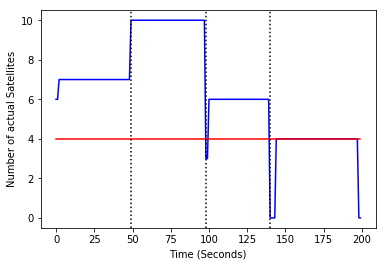

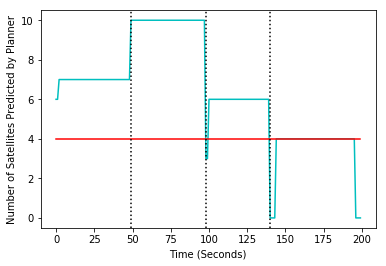

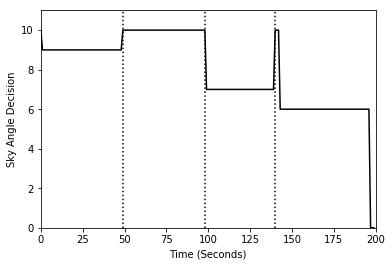

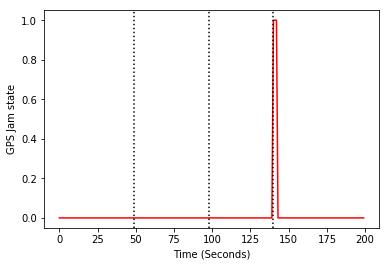

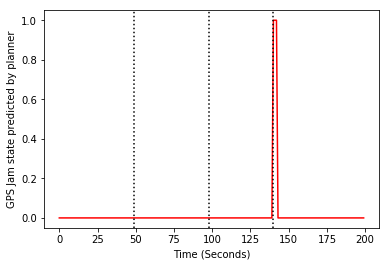

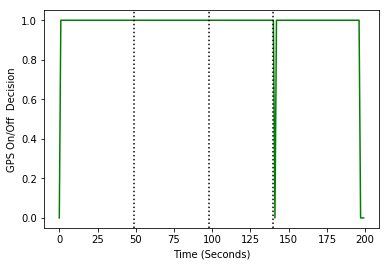

In [514]:
# Plotting the results
plt.plot(s_NumSat_Sim,'b')
plt.plot([4]*size_Sim,'r')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('Number of actual Satellites')
plt.xlabel('Time (Seconds)')
#plt.axis([0, size_Sim, 0, 17])
plt.show()

plt.plot(s_NumSat_Plan,'c')
plt.plot([4]*size_Sim,'r')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('Number of Satellites Predicted by Planner')
plt.xlabel('Time (Seconds)')
#plt.axis([0, size_Sim, 0, 17])
plt.show()

plt.plot(u_SkyAngle_Sim, 'k')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('Sky Angle Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, 0, 11])
plt.show()

plt.plot(s_Jam_Sim, 'r')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('GPS Jam state')
plt.xlabel('Time (Seconds)')
plt.show()

plt.plot(s_Jam_Plan, 'r')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('GPS Jam state predicted by planner')
plt.xlabel('Time (Seconds)')
plt.show()

plt.plot(u_Power_Sim, 'g')
plt.axvline(x=49, color = 'k', linestyle='dotted')
plt.axvline(x=98, color = 'k', linestyle='dotted')
plt.axvline(x=140, color = 'k', linestyle='dotted')
plt.ylabel('GPS On/Off  Decision')
plt.xlabel('Time (Seconds)')
plt.show()